In [2]:
import cv2
import json
import numpy as np
import openvino as ov
import matplotlib.pyplot as plt

In [3]:
core = ov.Core()

In [4]:
def load_model(model):
    if(model=='pedestrian-and-vehicle-detector-adas-0001'):
        model = core.read_model(model='./models/pedestrian-and-vehicle-detector-adas-0001.xml')
    elif(model=='person-vehicle-bike-detection-crossroad-0078'):
        model = core.read_model(model='./models/person-vehicle-bike-detection-crossroad-0078.xml')
    else:
        print('no model found!')
        return 0
    
    compiled_model = core.compile_model(model=model, device_name='CPU')
    input_layer_ir = compiled_model.input(0)
    output_layer_ir = compiled_model.output(0)
    N, C, H, W = input_layer_ir.shape
    return compiled_model, H, W, output_layer_ir

In [5]:
def preprocess(frame, H, W):
    """
    Preprocess the frame for openvino model.
    """
    image_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    resized_image = cv2.resize(image_bgr, (W, H))
    # Reshape to the network input shape.
    input_image = np.expand_dims(
        resized_image.transpose(2, 0, 1), 0
    )  
    return input_image

In [36]:
def postprocess(frame, model_name, model_result, height, width):
    """
    Postprocess the frame for visualization.
    """
    colormap = [(68, 1, 84), (51, 255, 119), (53, 183, 120), (199, 216, 52)]
    for result in model_result[0][0]:
        score = result[2]
        if (score>.70):
            x1, y1, x2, y2 = int(result[3] * width), int(result[4] * height), int(result[5] * width), int(result[6] * height)

            det_label = 'vehicle' if result[1]==1 else 'pedestrian'
            color =  colormap[0] if result[1]==1 else colormap[1]
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 1)
            cv2.putText(frame, '{} {:.1%}'.format(det_label, score),
                        (x1, y1 - 7), cv2.FONT_HERSHEY_COMPLEX, .5, color, 1)
            return x1, y1, x2, y2, det_label, score, color

In [37]:
model_name = 'pedestrian-and-vehicle-detector-adas-0001'
img_file_path = './data/test2.jpg'

In [38]:
compiled_model, H, W, output_layer_ir = load_model(model_name)
img = cv2.imread(img_file_path)

In [39]:
# Preprocess the frame
height, width, _ = img.shape
input_image = preprocess(img, H, W)

In [40]:
# Perform inference
result = compiled_model([input_image])[output_layer_ir]

In [41]:
# Post-processing steps here...
x1, y1, x2, y2, det_label, score, color = postprocess(img, model_name, result, height, width)

In [42]:
cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness=1)
cv2.putText(img, '{} {:.1%}'.format(det_label, score),
            (x1, y1 - 7), cv2.FONT_HERSHEY_COMPLEX, .5, color=(68, 1, 84), thickness=1)

array([[[ 36,  60,  30],
        [ 41,  68,  35],
        [ 44,  74,  45],
        ...,
        [246, 248, 248],
        [246, 248, 248],
        [246, 248, 248]],

       [[ 38,  62,  32],
        [ 43,  70,  37],
        [ 44,  74,  45],
        ...,
        [246, 248, 248],
        [246, 248, 248],
        [246, 248, 248]],

       [[ 41,  65,  33],
        [ 44,  70,  40],
        [ 42,  72,  43],
        ...,
        [246, 248, 248],
        [246, 248, 248],
        [246, 248, 248]],

       ...,

       [[153, 148, 139],
        [158, 155, 147],
        [163, 159, 154],
        ...,
        [175, 163, 153],
        [166, 154, 144],
        [162, 150, 140]],

       [[167, 161, 150],
        [178, 171, 162],
        [170, 164, 157],
        ...,
        [169, 157, 147],
        [168, 156, 146],
        [170, 158, 148]],

       [[157, 153, 148],
        [159, 153, 148],
        [177, 174, 166],
        ...,
        [167, 155, 145],
        [179, 167, 157],
        [178, 166, 156]]

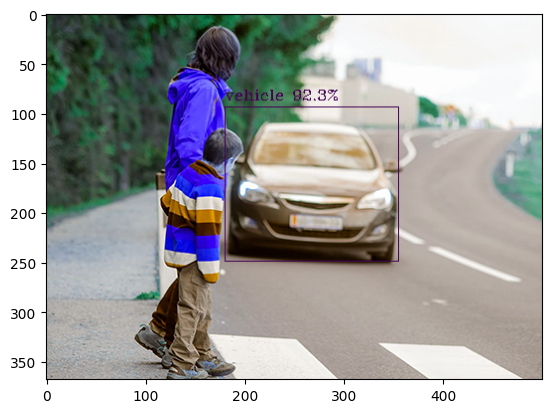

In [43]:
plt.imshow(img)